<a href="https://colab.research.google.com/github/israa2050/facial-emotion-detection/blob/main/Emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import libraries and installation**


In [2]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 38.1 MB/s eta 0:00:00


In [4]:
#connect with kaggle API with a token uploaded as "kaggle.json" file
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from glob import glob 
import keras
from keras.applications.vgg16 import VGG16 , preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential ,Model
from keras.layers import Dense, Dropout, Activation ,BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D 
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam,Adamax
from tensorflow import keras;   
from keras import layers;
from keras import metrics
import tensorflow as tf
import tensorflow_addons as tfa
from keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras import callbacks
from keras import regularizers

### **Import Dataset**

In [5]:
! kaggle datasets download -d msambare/fer2013

 96% 58.0M/60.3M [00:03<00:00, 22.0MB/s]
100% 60.3M/60.3M [00:04<00:00, 15.7MB/s]


In [6]:
! unzip "/content/fer2013.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [7]:
num_of_classes = 7
train_path = "/content/train"
test_path = "/content/test"
image_size = [48,48]
batch_size = 64

# **Make some visualization**

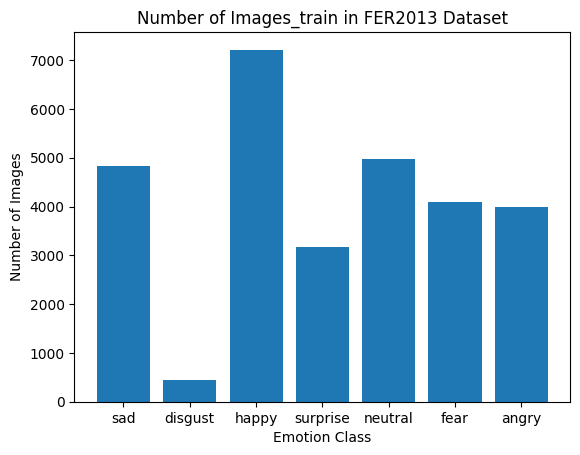

In [ ]:
# Create a dictionary to store the number of images in each class
counts = {}

# Loop over the subdirectories and count the number of images in each class
for subdir in os.listdir(train_path):
    if os.path.isdir(os.path.join(train_path, subdir)):
        counts[subdir] = len(os.listdir(os.path.join(train_path, subdir)))

# Plot the bar chart
plt.bar(range(len(counts)), list(counts.values()))
plt.title('Number of Images_train in FER2013 Dataset')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Images')
plt.xticks(range(len(counts)), list(counts.keys()))
plt.show()

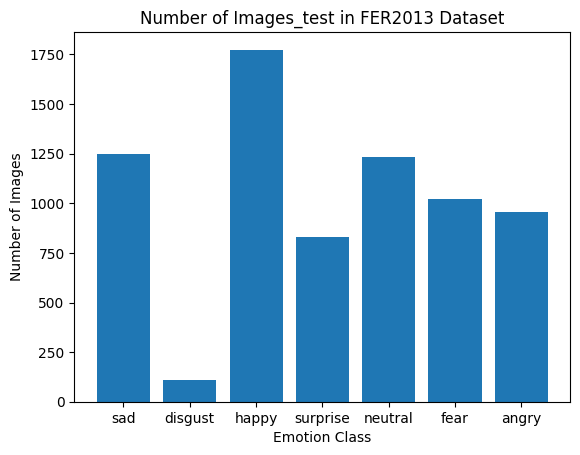

In [ ]:
# Create a dictionary to store the number of images in each class
counts = {}

# Loop over the subdirectories and count the number of images in each class
for subdir in os.listdir(test_path):
    if os.path.isdir(os.path.join(test_path, subdir)):
        counts[subdir] = len(os.listdir(os.path.join(test_path, subdir)))

# Plot the bar chart
plt.bar(range(len(counts)), list(counts.values()))
plt.title('Number of Images_test in FER2013 Dataset')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Images')
plt.xticks(range(len(counts)), list(counts.keys()))
plt.show()

## Load data and make augmentation

In [8]:
train_data_gen = ImageDataGenerator(
					rotation_range=10,
					shear_range=0.2,
					horizontal_flip=True,
					rescale=1./255)
validation_data_gen = ImageDataGenerator(rescale=1./255)

In [9]:
# Preprocess all test images
train_generator = train_data_gen.flow_from_directory(
        train_path,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

# Preprocess all train images
validation_generator = validation_data_gen.flow_from_directory(
        test_path,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# **Model Architecture**

In [35]:
model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))


#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256,kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Dense(num_of_classes, activation='softmax'))

In [36]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 activation_39 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 24, 24, 128)       204928    
                                                                 
 activation_40 (Activation)  (None, 24, 24, 128)       0         
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 12, 12, 128)      0         
 g2D)                                                 

In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001, decay=1e-6),
              metrics=['accuracy',tfa.metrics.F1Score(num_classes=7,average='macro' )])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [38]:
early_stop = callbacks.EarlyStopping(patience = 20 , monitor = 'val_loss')

In [39]:
# Train the neural network/model
history = model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=15,
        validation_data=validation_generator,
        validation_steps=7178 // 64,
        callbacks = [early_stop])

Epoch 1/15


<ipython-input-39-b661e8a1f435>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


448/448 [==============================] - 32s 69ms/step - loss: 4.0435 - accuracy: 0.3090 - f1_score: 0.2285 - val_loss: 2.8233 - val_accuracy: 0.3887 - val_f1_score: 0.2945
Epoch 2/15
448/448 [==============================] - 29s 64ms/step - loss: 2.1443 - accuracy: 0.4230 - f1_score: 0.3301 - val_loss: 1.8935 - val_accuracy: 0.4572 - val_f1_score: 0.3607
Epoch 3/15
448/448 [==============================] - 30s 68ms/step - loss: 1.6744 - accuracy: 0.4777 - f1_score: 0.3833 - val_loss: 1.5622 - val_accuracy: 0.5007 - val_f1_score: 0.3895
Epoch 4/15
448/448 [==============================] - 29s 64ms/step - loss: 1.4570 - accuracy: 0.5181 - f1_score: 0.4220 - val_loss: 1.4305 - val_accuracy: 0.5208 - val_f1_score: 0.4161
Epoch 5/15
448/448 [==============================] - 28s 63ms/step - loss: 1.3453 - accuracy: 0.5363 - f1_score: 0.4380 - val_loss: 1.3248 - val_accuracy: 0.5379 - val_f1_score: 0.4479
Epoch 6/15
448/448 [==============================] - 31s 68ms/step - loss: 1.270

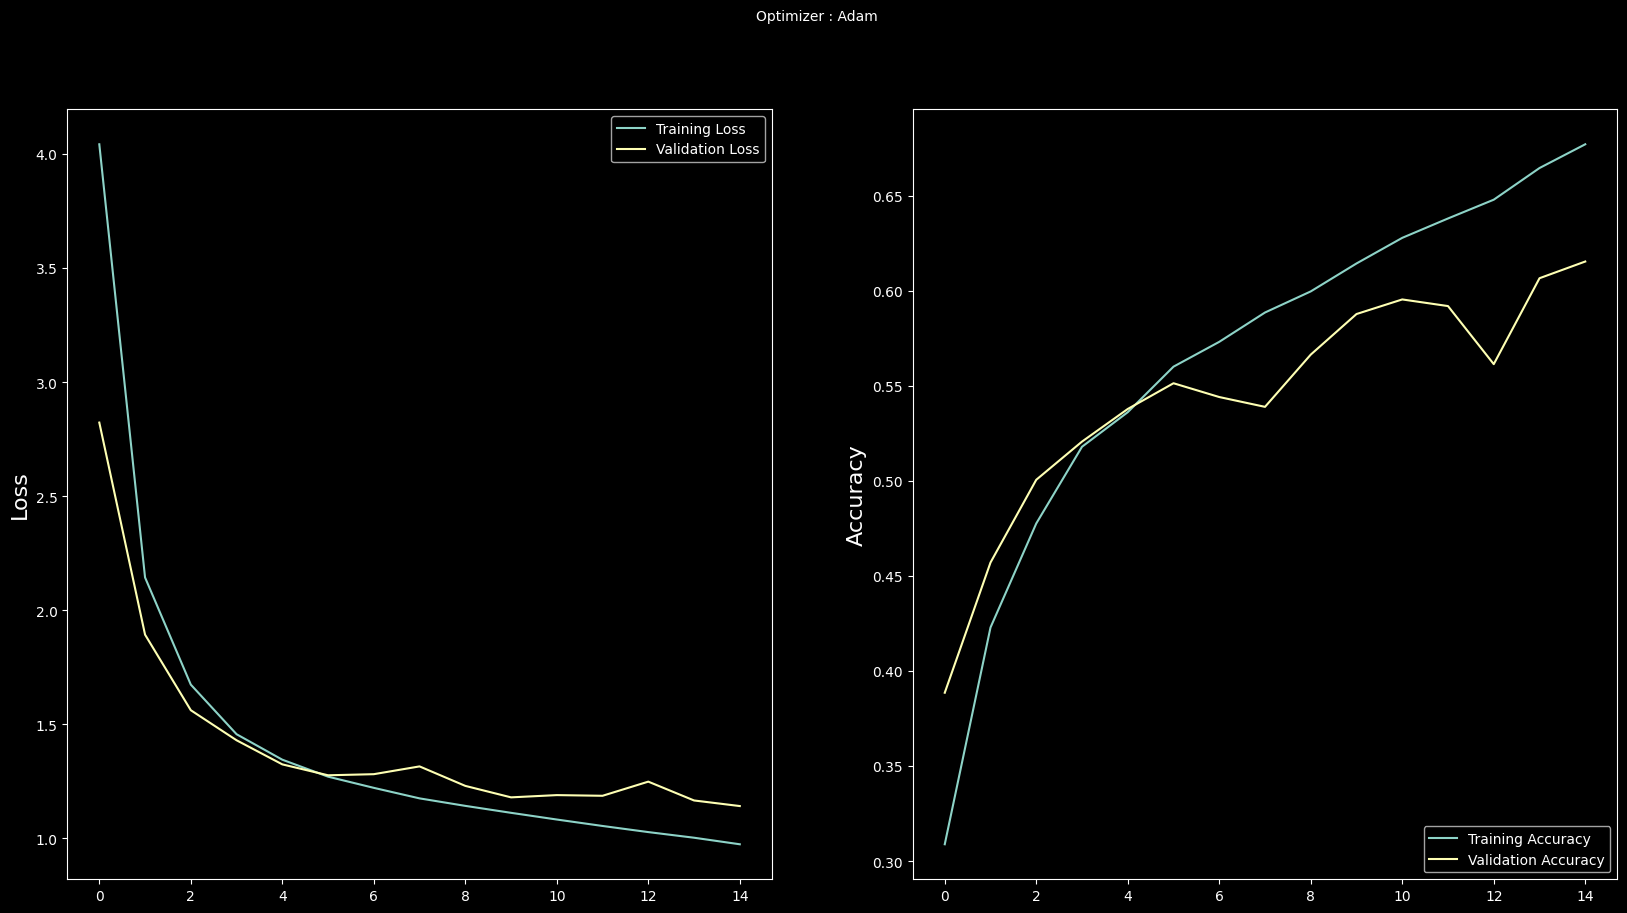

In [40]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [42]:
# save model 
model.save('emotionl.h5')

#**Testing the model**

1/1 [==============================] - 0s 292ms/step
[[0.02924766 0.00135391 0.05117576 0.0100863  0.35653412 0.53588474
  0.01571742]]
5
The predicted emotion in the image is: sad


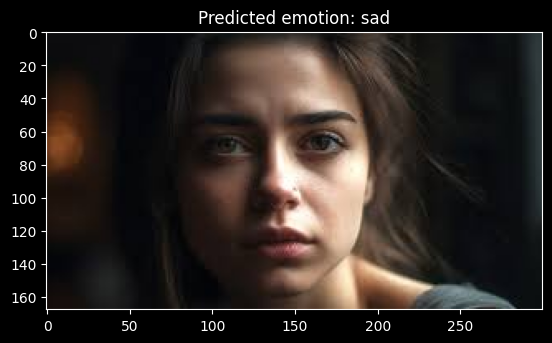

In [43]:
# Preprocess image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (48, 48))
    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    return image
model = tf.keras.models.load_model('/content/emotionl.h5')
# Define a function to predict the emotion in the image
def predict_emotion(image_path):
    emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
    image = preprocess_image(image_path)
    prediction = model.predict(image)
    print(prediction)
    predicted_class = np.argmax(prediction)
    print(predicted_class)
    emotion = emotion_labels[predicted_class]
    return emotion

# Test the function on an example image
image_path = '/content/images.jpeg'
emotion = predict_emotion(image_path)
print('The predicted emotion in the image is:', emotion)

# Display the image with the predicted emotion label
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Predicted emotion: ' + emotion)
plt.show()